Thermal Convection
======

This example solves 2D dimensionless isoviscous thermal convection with a Rayleigh number of $10^4$, see Blankenbach *et al.* 1989 for details.

**This example introduces:**
1. Setting up material parameters and functions.
2. Setting up and solving systems, Stokes and Advection Diffusion.
3. The time stepping loop.
4. Plotting with glucifer.

**Keywords:** material parameters, Stokes system, advective diffusive systems

**References**

B. Blankenbach, F. Busse, U. Christensen, L. Cserepes, D. Gunkel, U. Hansen, H. Harder, G. Jarvis, M. Koch, G. Marquart, D. Moore, P. Olson, H. Schmeling and T. Schnaubelt. A benchmark comparison for mantle convection codes. Geophysical Journal International, 98, 1, 23–38, 1989
http://onlinelibrary.wiley.com/doi/10.1111/j.1365-246X.1989.tb05511.x/abstract

In [17]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
import numpy as np



Setup parameters
-----

In [2]:
# Set simulation box size.
boxHeight = 1.0
boxLength = 2.0
# Set the resolution.
res = 16
# Set min/max temperatures.
tempMin = 0.0
tempMax = 1.0

Create mesh and variables
------

The mesh object has both a primary and sub mesh. "Q1/dQ0" produces a primary mesh with element type Q1 and a sub-mesh with elements type dQ0. Q1 elements have nodes at the element corners, dQ0 elements have a single node at the elements centre.

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (2*res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

Create mesh variables.  Note the pressure field uses the sub-mesh. 

In [4]:
velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

# Initialise values
velocityField.data[:]       = [0.,0.]
pressureField.data[:]       = 0.
temperatureDotField.data[:] = 0.

Set up material parameters and functions
-----

Set functions for viscosity, density and buoyancy force. These functions and variables only need to be defined at the beginning of the simulation, not each timestep.

In [5]:
# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0e4

# Construct our density function.
densityFn = Ra * temperatureField

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Create initial & boundary conditions
----------

Set a sinusoidal perturbation in the temperature field to seed the onset of convection.

In [6]:
pertStrength = 0.2
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

Set top and bottom wall temperature boundary values.

In [7]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

Construct sets for ``I`` (vertical) and ``J`` (horizontal) walls.

In [8]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Create Direchlet, or fixed value, boundary conditions. More information on setting boundary conditions can be found in the **Systems** section of the user guide.

In [9]:
# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)
velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls, jWalls) )

# Temperature is held constant on the jWalls
tempBC = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                           indexSetsPerDof = (jWalls,) )

**Render initial conditions for temperature**



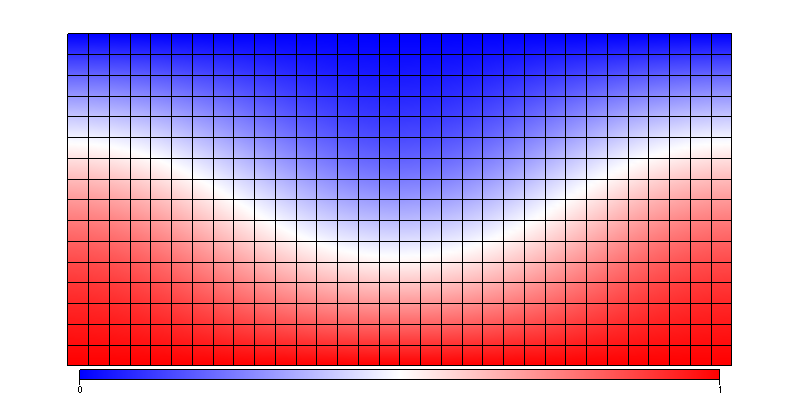

In [10]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

System setup
-----

**Setup a Stokes system**

Underworld uses the Stokes system to solve the incompressible Stokes equations.  

In [11]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = velBC,
                            fn_viscosity  = viscosity, 
                            fn_bodyforce  = buoyancyFn )

# get the default stokes equation solver
solver = uw.systems.Solver( stokes )

**Set up the advective diffusive system**

Underworld uses the AdvectionDiffusion system to solve the temperature field given heat transport through the velocity field. More information on the advection diffusion equation can be found [here](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation).

In [12]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = tempBC )

## Fault swarm

In [13]:
from unsupported_dan.interfaces.marker2D import markerLine2D
from unsupported_dan.faults.faults2D import fault2D, fault_collection

/workspace/2dthermalslabs/kaplan/unsupported_dan/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """
/workspace/2dthermalslabs/kaplan/unsupported_dan/faults/__init__.py:9: UserWarning: 

The fault module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [18]:
def PointsInCircum(r,n=100):
    return np.array([(math.cos(2*np.pi/n*x)*r,math.sin(2*np.pi/n*x)*r) for x in xrange(0,n+1)])

In [19]:
points = PointsInCircum(0.2,n=100)
points[:,1] += 0.5
points[:,0] += 1.



In [20]:
mean_dist = 2*np.pi*0.2/100
mean_dist

0.012566370614359173

In [21]:
fault  = fault2D(mesh, velocityField, points[:,0], points[:,1], 0.02, 0., 0., 1)


A very simple healing algorithm. 

* choose every second point, and get its immediate neighbours. 
* if the neighbouring point is too far away, create a new point
* if the neighbourning point is tto close, earmark for deletion
* if the current point is too far away from the line connecting it's nieghbours, move ot to that line.

In [24]:
#start = np.random.randint(2)
#points = fault.swarm.particleCoordinates.data[start::2]
#indexes = 
#diffs = #np.linalg.norm(np.diff(fault.swarm.particleCoordinates.data, axis = 0), axis=1)

In [25]:
#np.linalg.norm(np.diff(fault.swarm.particleCoordinates.data, axis = 0), axis=1)

In [27]:
#from scipy.interpolate import spline
#spline(xk, yk, xnew, order=3)

Main time stepping loop
-----

In [28]:
# init these guys
time = 0.
step = 0
steps_end = 2

# perform timestepping
while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    
    dt = advDiff.get_max_dt()
    advDiff.integrate(dt)
    fault.advection(dt)
    time += dt
    step +=1
    


**Plot final temperature and velocity field**


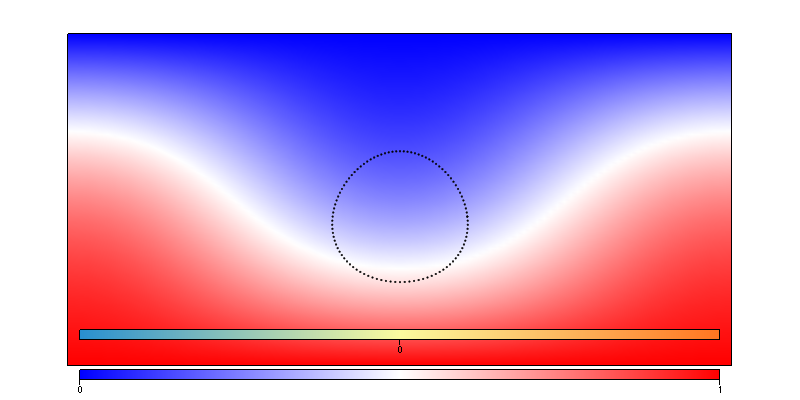

In [29]:
# plot figure
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
#figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )
figtemp.append( glucifer.objects.Points(fault.swarm, pointSize=3))
fault 
figtemp.show()

## invariants of the Strain rate tensor

In [99]:
sym_strainRate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )


ssr = sym_strainRate.evaluate(mesh)


eig1       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )

eig2       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )

for ti, val in enumerate(eig1.data):
    eigVals, eigVex= np.linalg.eigh(np.array([[ssr[ti][0],ssr[ti][2]],[ssr[ti][2],ssr[ti][1]]]), UPLO='U')
    #eig1.data[ti] = meshVisc.data[ti]*eigVals[0]*eigVex[0]
    #eig2.data[ti] = meshVisc.data[ti]*eigVals[1]*eigVex[1]
    eig1.data[ti] = eigVex[0]
    eig2.data[ti] = eigVex[1]

In [106]:
#eigVals, eigVex= np.linalg.eigh(np.array([[ssr[ti][0],ssr[ti][2]],[ssr[ti][2],ssr[ti][1]]]), UPLO='U')
#np.array([[ssr[ti][0],ssr[ti][2]],[ssr[ti][2],ssr[ti][1]]]).shape
#np.array([[1,2],[3,4]])

### Look at the stress tensor in cartesian and polar coords





In [60]:
#construct an atan2 function, for angle around origin
import operator
import numpy as np
coordinate = fn.input()

#construct an atan2 function, for angle around origin 

origin = (0.5, 0.5)

xrel = coordinate[0] - origin[0]
yrel = coordinate[1] - origin[1]

yoverx = yrel/xrel
xeq0 = operator.and_(xrel + 1e-20 > 0., xrel - 1e-20 < 0. )
yeq0 = operator.and_(yrel + 1e-20 > 0., yrel - 1e-20 < 0. )


conditions = [ ( xrel > 0. ,                      fn.math.atan(yoverx) ),
               ( operator.and_(xrel < 0.,yrel >= 0. ) ,   fn.math.atan(yoverx) + np.pi),
               ( operator.and_(xrel < 0.,yrel < 0. ) ,     fn.math.atan(yoverx) - np.pi),
               ( operator.and_(xeq0, yrel > 0. ) ,     np.pi/2.),
               ( operator.and_(xeq0, yrel < 0. ) ,     -1.*np.pi/2.),
               ( operator.and_(xeq0, yrel == 0. ) ,     fn.math.atan(yoverx) - np.pi),
               ( True,                                    9999999.) ]

thetaField= fn.branching.conditional( conditions )

In [82]:
#make an Nx4 mesh variable to store a transformation matrix

#for notes on transformation, see
#http://www.brown.edu/Departments/Engineering/Courses/En221/Notes/Polar_Coords/Polar_Coords.htm
#2.7 Converting tensors between Cartesian and Spherical-Polar bases

#Note that this is NOT how uw2 stores the tensor components
poltoCart    = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=4 )
#######        ##############
# 0 1 #   ===> # cosX sinX #      ===> Q
# 2 3 #        # -sinX  cosX #
#######        ##############

#Set the elements of this guy
poltoCart.data[:,0] = np.cos(thetaField.evaluate(mesh)[:,0])
poltoCart.data[:,1] = np.sin(thetaField.evaluate(mesh)[:,0])
poltoCart.data[:,2] = -1.*np.sin(thetaField.evaluate(mesh)[:,0])
poltoCart.data[:,3] = np.cos(thetaField.evaluate(mesh)[:,0])

In [83]:
#Construct and populate the cartesian and polar stress tensors

#take uw2 2-D tensor components:

#######        
# 0 2 #  
# . 1 #  
####### 

#and put them in to the form above

#######        
# 0 1 #  
# 2 3 #  
####### 

stressTensor = uw.mesh.MeshVariable( mesh, 4)
stressTensor.data[:,0] = 2.*viscosity*fn.tensor.symmetric( velocityField.fn_gradient ).evaluate(mesh)[:,0] 
stressTensor.data[:,1] = 2.*viscosity*fn.tensor.symmetric( velocityField.fn_gradient ).evaluate(mesh)[:,2] 
stressTensor.data[:,2] = 2.*viscosity*fn.tensor.symmetric( velocityField.fn_gradient ).evaluate(mesh)[:,2] 
stressTensor.data[:,3] = 2.*viscosity*fn.tensor.symmetric( velocityField.fn_gradient ).evaluate(mesh)[:,1] 


polarstressTensor = uw.mesh.MeshVariable( mesh, 4)

for i, val in enumerate(mesh.data):
    Q = poltoCart.data[i].reshape((2, 2))
    S = stressTensor.data[i].reshape((2, 2))
    RH = np.dot(S,Q.T)
    LH = np.dot(Q,RH)
    polarstressTensor.data[i] = np.ravel(LH)


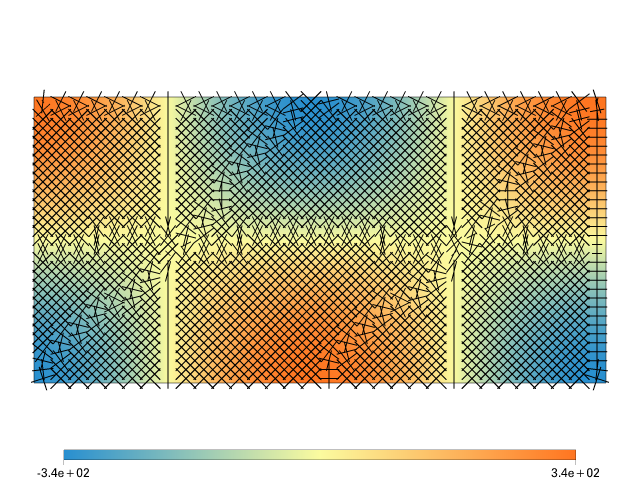

In [98]:
fig= glucifer.Figure(quality=3)
fig.append( glucifer.objects.VectorArrows(mesh,eig1,arrowHead=0., scaling=1e-1, resolutionI=16*2, resolutionJ=16*2 ))
fig.append( glucifer.objects.VectorArrows(mesh,eig2,arrowHead=0., scaling=1e-1, resolutionI=16*2, resolutionJ=16*2 ))

fig.append( glucifer.objects.Surface(mesh,stressTensor[0]))
#fig.append( glucifer.objects.Surface(mesh,polarstressTensor[1]))
#fig.append( glucifer.objects.Surface(mesh,thetaField))

#fig.append( glucifer.objects.VectorArrows(mesh,eig1*restFn,arrowHead=0., scaling=1e-2, resolutionI=16*2, resolutionJ=16*2 ))
#fig.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, arrowHead=0.2, scaling=0.1) )


fig.show()
##
#fig.save_database('test.gldb')

In [88]:
#check that the tensor contaractions are the same
print(np.dot(polarstressTensor.data[1], polarstressTensor.data[1]))
print(np.dot(stressTensor.data[1], stressTensor.data[1]))

214181.317315
214181.317315
